# ***`ASSET PRICING WITH LSTM + AUTOENCODER`***


------
------







# SETUP




In [ ]:
import os
import random
import tqdm
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential
from scipy import stats
from pprint import pprint
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline

from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

%matplotlib inline

np.set_printoptions(precision=4, suppress=True)

tf.random.set_seed(100)

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# USING GPU 

In [ ]:
# Get the list of available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

# Limit GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        
# If there is at least one GPU available, set it to be used
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Set visible devices to be used
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Print the available and logical GPUs
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # In case of any errors, fall back to CPU
        print(e)
        device = '/device:CPU:0'
else:
    print("No GPUs available, using CPU instead")
    device = '/device:CPU:0'

1 Physical GPUs, 1 Logical GPUs


# PRE PROCESSING THE DATA


In [ ]:
from google.colab import drive

# Mounting the Google drive to read the data
drive.mount('/drive')

# Data Importing
dd = pd.read_csv(('/drive/My Drive/Colab Notebooks/Data/equity_2000_2020.csv'), parse_dates=['DATE'])

dd.sort_values('DATE', inplace=True)
dd.set_index('DATE', inplace=True)

# Removing useless columns in the dataset
dd.drop(columns=['Unnamed: 0'], inplace=True)

# Filter data from 2016-2020
df = dd['2016-07-29':'2020-01-31']

df.head(10)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


,permno,RET,mvel1,prc,SHROUT,beta,betasq,chmom,dolvol,idiovol,...,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,bm,bm_ia
DATE,,,,,,,,,,,,,,,,,,,,,
2016-07-29,85314.0,0.021960,5.544650e+04,17.679899,3206.0,0.619577,0.383876,0.067509,9.566825,0.042310,...,0.031709,5.580000e-06,0.055880,0.021364,2.132901,1.061602,1.240000e-07,73.0,0.295230,-0.164131
2016-07-29,85340.0,0.014361,6.094650e+05,16.280001,37808.0,-0.034024,0.001158,0.059744,12.693825,0.014847,...,0.008381,2.630000e-09,0.008895,0.005342,0.384365,1.110735,2.920000e-08,67.0,0.587311,-0.129934
2016-07-29,85339.0,0.003781,4.775649e+05,15.340000,31132.0,-0.008510,0.000072,-0.025287,12.385099,0.013247,...,0.007318,3.990000e-09,0.007314,0.003521,0.381065,0.787082,5.010000e-08,67.0,0.587311,-0.129934
2016-07-29,85337.0,0.061512,1.706276e+05,52.020000,3454.0,0.809356,0.655057,0.093288,12.239133,0.033486,...,0.016738,2.750000e-08,0.026064,0.017757,0.606336,4.088475,1.820000e-08,20.0,10.766907,5.366652
2016-07-29,85332.0,0.045014,2.114073e+05,36.680000,6030.0,0.964580,0.930414,0.049906,11.547285,0.025500,...,0.024221,3.190000e-08,0.023961,0.014717,0.594446,1.862506,4.310000e-08,60.0,0.746800,-0.076805
2016-07-29,85320.0,-0.127869,2.131950e+04,7.980000,2330.0,0.187350,0.035100,1.538280,5.463228,0.155574,...,0.154107,7.700000e-06,0.485981,0.145591,2.403231,112.700337,1.300000e-10,73.0,0.579862,0.120502
2016-07-29,85319.0,0.001105,3.801976e+06,45.310001,84003.0,0.869740,0.756448,0.047188,14.361088,0.028935,...,0.015899,9.280000e-10,0.034278,0.015411,0.416535,1.405638,3.290000e-08,73.0,0.304966,-0.154394
2016-07-29,85299.0,0.098277,1.170267e+06,51.349998,25058.0,0.854367,0.729943,-0.067012,13.384019,0.023279,...,0.019526,5.740000e-09,0.027153,0.017771,0.475575,1.755443,2.920000e-08,60.0,0.509236,-0.314368
2016-07-29,85271.0,0.040430,3.367041e+06,16.469999,215452.0,0.893780,0.798843,0.130221,16.248879,0.025935,...,0.009144,1.490000e-10,0.017341,0.006536,0.408870,4.873648,7.710000e-09,67.0,1.460924,0.893274


In [ ]:
# Print information regarding dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246825 entries, 2016-07-29 to 2020-01-31
Data columns (total 100 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   permno           246825 non-null  float64
 1   RET              246825 non-null  float64
 2   mvel1            246825 non-null  float64
 3   prc              246825 non-null  float64
 4   SHROUT           246825 non-null  float64
 5   beta             246825 non-null  float64
 6   betasq           246825 non-null  float64
 7   chmom            246825 non-null  float64
 8   dolvol           246825 non-null  float64
 9   idiovol          246825 non-null  float64
 10  indmom           246825 non-null  float64
 11  mom1m            246825 non-null  float64
 12  mom6m            246825 non-null  float64
 13  mom12m           246825 non-null  float64
 14  mom36m           246825 non-null  float64
 15  mve0             246825 non-null  float64
 16  pricedelay       2468

# SPLITTING THE DATA INTO TRAIN & TEST

In [ ]:
# Total number of days in the dataset
Time_diff = df.index[-1] - df.index[0]
print(Time_diff.days, 'days in the dataset')
print(np.count_nonzero(df['permno'].unique()), 'stocks in total in the datasets')

# Ratio of data for test
test_ratio = 0.25

# Index splitting train and test data
test_index = df.index[0] + (Time_diff*(1-test_ratio))

# Creating a new column of test flag
df['test_flag'] = False                                  #all false for training
df.loc[ test_index : df.index[-1], 'test_flag' ] = True  #some data for testing based on test_ratio

1281 days in the dataset
7063 stocks in total in the datasets



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Visual Representation of Train and Test Splits - Example
def plot_stock(stockID):
    
    plt.figure(figsize=(9,6))
    
    df[(df['permno']==stockID)&(df['test_flag']==False)]['RET'].plot()
    df[(df['permno']==stockID)&(df['test_flag']==True)]['RET'].plot()
    
    plt.title('Example of Training/Testing Split')
    plt.legend(['Training','Testing'])
    plt.show()

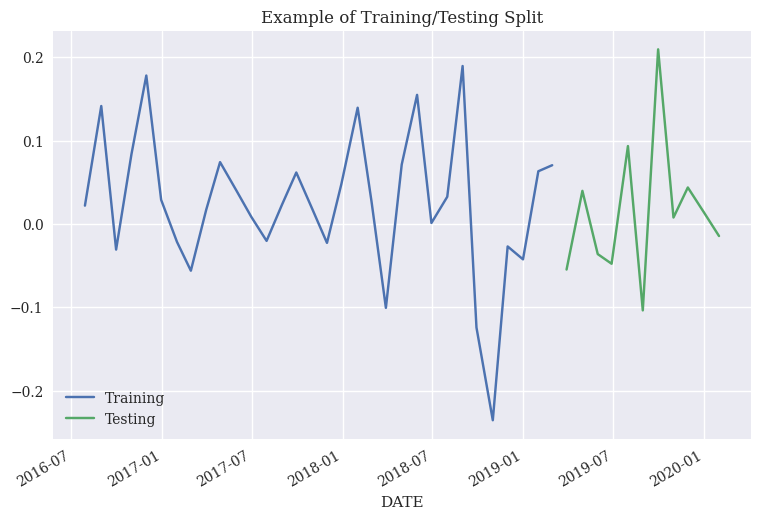

In [ ]:
plot_stock(85314)

# AUTOENCODER + LSTM (MODEL 1)

In [ ]:
# Creating a generator for LSTM Windows and Labels

sequence_length = 8

def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

# LSTM input features
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


# LSTM output features
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [ ]:
# Train/Test data

col = df.columns

X_train, X_test = [], []
y_train, y_test = [], []

for (stock,is_test), _df in df.groupby(['permno', 'test_flag']):
    
    for seq in gen_sequence(_df, sequence_length, col):        
        if is_test:
            X_test.append(seq)
        else:
            X_train.append(seq)
                
    for seq in gen_labels(_df, sequence_length, ['RET']):        
        if is_test:
            y_test.append(seq)
        else:
            y_train.append(seq)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print('shape of the intput X and output y\ninput training data dimension: ')
print(X_train.shape)
print('\noutput training data dimension: ')
print(y_train.shape)

print('\ninput testing data dimension: ')
print(X_test.shape)
print('\noutput testing data dimension: ')
print(y_test.shape)

# print several examples, only print 3 out of 101 features
for i in range(3):
    print('input ', i, ': \n',X_train[i,:,0:3])
    print('==> output ', i, ': \n', y_train[i], '\n')

shape of the intput X and output y
input training data dimension: 
(131436, 8, 101)

output training data dimension: 
(131436, 1)

input testing data dimension: 
(16557, 8, 101)

output testing data dimension: 
(16557, 1)
input  0 : 
 [[10001.0 0.026466 73478.87759]
 [10001.0 0.03662 74635.199]
 [10001.0 0.04212 77397.7614]
 [10001.0 0.619948 80657.7208]
 [10001.0 0.012146 129922.004]
 [10001.0 0.01 131500.0]
 [10001.0 0.007968 132026.002]
 [10001.0 0.0 133077.996]]
==> output  0 : 
 [0.0099] 

input  1 : 
 [[10001.0 0.03662 74635.199]
 [10001.0 0.04212 77397.7614]
 [10001.0 0.619948 80657.7208]
 [10001.0 0.012146 129922.004]
 [10001.0 0.01 131500.0]
 [10001.0 0.007968 132026.002]
 [10001.0 0.0 133077.996]
 [10001.0 0.009881 133077.996]]
==> output  1 : 
 [-0.0157] 

input  2 : 
 [[10001.0 0.04212 77397.7614]
 [10001.0 0.619948 80657.7208]
 [10001.0 0.012146 129922.004]
 [10001.0 0.01 131500.0]
 [10001.0 0.007968 132026.002]
 [10001.0 0.0 133077.996]
 [10001.0 0.009881 133077.996]
 [10

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

print(X_train.shape)

(131436, 8, 101)


# TRAINING THE MODEL

In [ ]:
# Construct model
set_seed(50)

# DEFINE LSTM AUTOENCODER
# Input shape is (4, 101), using 4 rows to forecast one output, each row has 101 features
inputs_ae = Input(shape=(X_train.shape[1:]))

# Encoding LSTM layer, receive inputs_ae from input layer
encoded_ae = LSTM(256, activation='relu', return_sequences=True)(inputs_ae)
encoded_ae = Dropout(0.2)(encoded_ae) # add dropout for regularization
encoded_ae = BatchNormalization()(encoded_ae)

# Decoding LSTM layer, receive encoded_ae from encoding LSTM layer
decoded_ae = LSTM(128, activation='relu', return_sequences=True)(encoded_ae)
decoded_ae = Dropout(0.2)(decoded_ae) # add dropout for regularization
decoded_ae = BatchNormalization()(decoded_ae)

# Output layer
out_ae = TimeDistributed(Dense(1))(decoded_ae)

# Define the autoencoder model
sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# TRAIN AUTOENCODER
es = EarlyStopping(patience=15, verbose=2, min_delta=0.001, 
                       monitor='val_loss', mode='auto', restore_best_weights=True)

# Train autoencoder with output reconstructing the input
sequence_autoencoder.fit(X_train, X_train, validation_data=(X_train, X_train),
                             batch_size=256, epochs=200, verbose=1, callbacks=[es])


Epoch 1/200
514/514 [==============================] - 23s 40ms/step - loss: 1.0993 - val_loss: 0.9784
Epoch 2/200
514/514 [==============================] - 18s 35ms/step - loss: 0.9782 - val_loss: 0.9754
Epoch 3/200
514/514 [==============================] - 22s 43ms/step - loss: 0.9757 - val_loss: 0.9744
Epoch 4/200
514/514 [==============================] - 18s 35ms/step - loss: 0.9750 - val_loss: 0.9740
Epoch 5/200
514/514 [==============================] - 19s 36ms/step - loss: 0.9746 - val_loss: 0.9739
Epoch 6/200
514/514 [==============================] - 18s 34ms/step - loss: 0.9743 - val_loss: 0.9739
Epoch 7/200
514/514 [==============================] - 18s 35ms/step - loss: 0.9742 - val_loss: 0.9742
Epoch 8/200
514/514 [==============================] - 18s 35ms/step - loss: 0.9741 - val_loss: 0.9740
Epoch 9/200
514/514 [==============================] - 18s 34ms/step - loss: 0.9740 - val_loss: 0.9738
Epoch 10/200
514/514 [==============================] - 18s 35ms/step - l

In [ ]:
# ENCODE PRICE AND CONCATENATE REGRESSORS
encoder = Model(inputs_ae, encoded_ae)
encoded_feature_train = encoder.predict(X_train)
encoded_feature_test = encoder.predict(X_test)

# Dimension of encoded features
print('encoded features: ', encoded_feature_train.shape)

X_train_ = np.concatenate([X_train, encoder.predict(X_train)], axis=-1)
X_test_ = np.concatenate([X_test, encoder.predict(X_test)], axis=-1)

X_train_.shape, X_test_.shape

518/518 [==============================] - 1s 3ms/step
encoded features:  (131436, 8, 256)
518/518 [==============================] - 1s 3ms/step


((131436, 8, 357), (16557, 8, 357))

# FORECASTER

In [ ]:
%%time

set_seed(50)

# DEFINE STANDARD LSTM FORECASTER
inputs = Input(shape=(X_train_.shape[1:]))
lstm = LSTM(256, return_sequences=True, dropout=0.5)(inputs, training=True)
lstm = LSTM(128, return_sequences=False, dropout=0.5)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

# FIT FORECASTER
es = EarlyStopping(patience=10, verbose=2, min_delta=0.001, 
                   monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train_, y_train, validation_data=(X_train_, y_train), 
          epochs=200, batch_size=256, verbose=1, callbacks=[es])

Epoch 1/200
514/514 [==============================] - 14s 18ms/step - loss: 0.0275 - val_loss: 0.0254
Epoch 2/200
514/514 [==============================] - 5s 11ms/step - loss: 0.0255 - val_loss: 0.0252
Epoch 3/200
514/514 [==============================] - 6s 11ms/step - loss: 0.0253 - val_loss: 0.0251
Epoch 4/200
514/514 [==============================] - 5s 11ms/step - loss: 0.0252 - val_loss: 0.0251
Epoch 5/200
514/514 [==============================] - 6s 11ms/step - loss: 0.0250 - val_loss: 0.0249
Epoch 6/200
514/514 [==============================] - 5s 11ms/step - loss: 0.0250 - val_loss: 0.0248
Epoch 7/200
514/514 [==============================] - 5s 11ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 8/200
514/514 [==============================] - 6s 11ms/step - loss: 0.0248 - val_loss: 0.0245
Epoch 9/200
514/514 [==============================] - 5s 10ms/step - loss: 0.0247 - val_loss: 0.0246
Epoch 10/200
514/514 [==============================] - 6s 11ms/step - loss: 0.02

In [ ]:
# COMPUTE STOCHASTIC DROPOUT 
%%time
scores = []
for i in tqdm.tqdm(range(0,100)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test_).ravel()))

print(np.mean(scores), np.std(scores))

  0%|          | 0/100 [00:00<?, ?it/s]

518/518 [==============================] - 2s 2ms/step


  1%|          | 1/100 [00:02<04:13,  2.56s/it]

518/518 [==============================] - 1s 2ms/step


  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

518/518 [==============================] - 1s 2ms/step


  3%|▎         | 3/100 [00:06<03:15,  2.02s/it]

518/518 [==============================] - 1s 3ms/step


  4%|▍         | 4/100 [00:08<03:13,  2.02s/it]

518/518 [==============================] - 1s 3ms/step


  5%|▌         | 5/100 [00:10<03:11,  2.02s/it]

518/518 [==============================] - 1s 2ms/step


  6%|▌         | 6/100 [00:12<03:03,  1.96s/it]

518/518 [==============================] - 1s 2ms/step


  7%|▋         | 7/100 [00:14<02:58,  1.92s/it]

518/518 [==============================] - 1s 2ms/step


  8%|▊         | 8/100 [00:15<02:55,  1.91s/it]

518/518 [==============================] - 1s 2ms/step


  9%|▉         | 9/100 [00:17<02:51,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 10%|█         | 10/100 [00:19<02:50,  1.89s/it]

518/518 [==============================] - 1s 3ms/step


 11%|█         | 11/100 [00:21<02:52,  1.94s/it]

518/518 [==============================] - 1s 3ms/step


 12%|█▏        | 12/100 [00:23<02:53,  1.97s/it]

518/518 [==============================] - 1s 2ms/step


 13%|█▎        | 13/100 [00:25<02:49,  1.94s/it]

518/518 [==============================] - 1s 2ms/step


 14%|█▍        | 14/100 [00:27<02:45,  1.93s/it]

518/518 [==============================] - 1s 2ms/step


 15%|█▌        | 15/100 [00:29<02:41,  1.90s/it]

518/518 [==============================] - 1s 2ms/step


 16%|█▌        | 16/100 [00:31<02:38,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 17%|█▋        | 17/100 [00:33<02:35,  1.87s/it]

518/518 [==============================] - 1s 3ms/step


 18%|█▊        | 18/100 [00:35<02:37,  1.92s/it]

518/518 [==============================] - 1s 3ms/step


 19%|█▉        | 19/100 [00:37<02:38,  1.95s/it]

518/518 [==============================] - 1s 2ms/step


 20%|██        | 20/100 [00:38<02:33,  1.91s/it]

518/518 [==============================] - 1s 2ms/step


 21%|██        | 21/100 [00:40<02:28,  1.88s/it]

518/518 [==============================] - 1s 2ms/step


 22%|██▏       | 22/100 [00:42<02:25,  1.87s/it]

518/518 [==============================] - 1s 2ms/step


 23%|██▎       | 23/100 [00:44<02:24,  1.87s/it]

518/518 [==============================] - 1s 2ms/step


 24%|██▍       | 24/100 [00:46<02:21,  1.86s/it]

518/518 [==============================] - 1s 3ms/step


 25%|██▌       | 25/100 [00:48<02:21,  1.89s/it]

518/518 [==============================] - 1s 3ms/step


 26%|██▌       | 26/100 [00:50<02:21,  1.92s/it]

518/518 [==============================] - 1s 2ms/step


 27%|██▋       | 27/100 [00:52<02:18,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 28%|██▊       | 28/100 [00:53<02:15,  1.88s/it]

518/518 [==============================] - 1s 2ms/step


 29%|██▉       | 29/100 [00:55<02:13,  1.88s/it]

518/518 [==============================] - 1s 2ms/step


 30%|███       | 30/100 [00:57<02:12,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 31%|███       | 31/100 [00:59<02:08,  1.87s/it]

518/518 [==============================] - 1s 3ms/step


 32%|███▏      | 32/100 [01:01<02:09,  1.90s/it]

518/518 [==============================] - 1s 3ms/step


 33%|███▎      | 33/100 [01:03<02:09,  1.93s/it]

518/518 [==============================] - 1s 2ms/step


 34%|███▍      | 34/100 [01:05<02:06,  1.91s/it]

518/518 [==============================] - 1s 2ms/step


 35%|███▌      | 35/100 [01:07<02:03,  1.90s/it]

518/518 [==============================] - 1s 2ms/step


 36%|███▌      | 36/100 [01:09<02:00,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 37%|███▋      | 37/100 [01:10<01:57,  1.87s/it]

518/518 [==============================] - 1s 2ms/step


 38%|███▊      | 38/100 [01:12<01:55,  1.86s/it]

518/518 [==============================] - 1s 3ms/step


 39%|███▉      | 39/100 [01:14<01:54,  1.87s/it]

518/518 [==============================] - 1s 3ms/step


 40%|████      | 40/100 [01:16<01:54,  1.92s/it]

518/518 [==============================] - 1s 2ms/step


 41%|████      | 41/100 [01:18<01:53,  1.92s/it]

518/518 [==============================] - 1s 2ms/step


 42%|████▏     | 42/100 [01:20<01:50,  1.91s/it]

518/518 [==============================] - 1s 2ms/step


 43%|████▎     | 43/100 [01:22<01:47,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 44%|████▍     | 44/100 [01:24<01:45,  1.88s/it]

518/518 [==============================] - 1s 3ms/step


 45%|████▌     | 45/100 [01:26<01:44,  1.89s/it]

518/518 [==============================] - 1s 3ms/step


 46%|████▌     | 46/100 [01:28<01:43,  1.91s/it]

518/518 [==============================] - 1s 3ms/step


 47%|████▋     | 47/100 [01:30<01:42,  1.93s/it]

518/518 [==============================] - 1s 2ms/step


 48%|████▊     | 48/100 [01:31<01:39,  1.92s/it]

518/518 [==============================] - 1s 2ms/step


 49%|████▉     | 49/100 [01:33<01:36,  1.90s/it]

518/518 [==============================] - 1s 3ms/step


 50%|█████     | 50/100 [01:35<01:34,  1.90s/it]

518/518 [==============================] - 1s 2ms/step


 51%|█████     | 51/100 [01:37<01:32,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 52%|█████▏    | 52/100 [01:39<01:29,  1.87s/it]

518/518 [==============================] - 1s 3ms/step


 53%|█████▎    | 53/100 [01:41<01:28,  1.89s/it]

518/518 [==============================] - 1s 3ms/step


 54%|█████▍    | 54/100 [01:43<01:28,  1.92s/it]

518/518 [==============================] - 1s 3ms/step


 55%|█████▌    | 55/100 [01:45<01:26,  1.93s/it]

518/518 [==============================] - 1s 2ms/step


 56%|█████▌    | 56/100 [01:47<01:23,  1.91s/it]

518/518 [==============================] - 1s 2ms/step


 57%|█████▋    | 57/100 [01:48<01:21,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 58%|█████▊    | 58/100 [01:50<01:18,  1.87s/it]

518/518 [==============================] - 1s 2ms/step


 59%|█████▉    | 59/100 [01:52<01:16,  1.87s/it]

518/518 [==============================] - 1s 3ms/step


 60%|██████    | 60/100 [01:54<01:15,  1.89s/it]

518/518 [==============================] - 1s 3ms/step


 61%|██████    | 61/100 [01:56<01:15,  1.93s/it]

518/518 [==============================] - 1s 3ms/step


 62%|██████▏   | 62/100 [01:58<01:13,  1.93s/it]

518/518 [==============================] - 1s 2ms/step


 63%|██████▎   | 63/100 [02:00<01:10,  1.90s/it]

518/518 [==============================] - 1s 2ms/step


 64%|██████▍   | 64/100 [02:02<01:08,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 65%|██████▌   | 65/100 [02:04<01:05,  1.88s/it]

518/518 [==============================] - 1s 2ms/step


 66%|██████▌   | 66/100 [02:05<01:03,  1.86s/it]

518/518 [==============================] - 1s 2ms/step


 67%|██████▋   | 67/100 [02:07<01:01,  1.87s/it]

518/518 [==============================] - 1s 3ms/step


 68%|██████▊   | 68/100 [02:09<01:01,  1.91s/it]

518/518 [==============================] - 1s 3ms/step


 69%|██████▉   | 69/100 [02:11<01:00,  1.94s/it]

518/518 [==============================] - 1s 2ms/step


 70%|███████   | 70/100 [02:13<00:57,  1.92s/it]

518/518 [==============================] - 1s 3ms/step


 71%|███████   | 71/100 [02:15<00:55,  1.91s/it]

518/518 [==============================] - 1s 2ms/step


 72%|███████▏  | 72/100 [02:17<00:52,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 73%|███████▎  | 73/100 [02:19<00:50,  1.88s/it]

518/518 [==============================] - 1s 2ms/step


 74%|███████▍  | 74/100 [02:21<00:49,  1.89s/it]

518/518 [==============================] - 1s 3ms/step


 75%|███████▌  | 75/100 [02:23<00:48,  1.92s/it]

518/518 [==============================] - 1s 3ms/step


 76%|███████▌  | 76/100 [02:25<00:46,  1.94s/it]

518/518 [==============================] - 1s 2ms/step


 77%|███████▋  | 77/100 [02:27<00:44,  1.93s/it]

518/518 [==============================] - 1s 2ms/step


 78%|███████▊  | 78/100 [02:28<00:42,  1.91s/it]

518/518 [==============================] - 1s 2ms/step


 79%|███████▉  | 79/100 [02:31<00:47,  2.24s/it]

518/518 [==============================] - 1s 2ms/step


 80%|████████  | 80/100 [02:33<00:42,  2.12s/it]

518/518 [==============================] - 1s 3ms/step


 81%|████████  | 81/100 [02:35<00:39,  2.09s/it]

518/518 [==============================] - 1s 3ms/step


 82%|████████▏ | 82/100 [02:37<00:37,  2.07s/it]

518/518 [==============================] - 1s 2ms/step


 83%|████████▎ | 83/100 [02:39<00:34,  2.01s/it]

518/518 [==============================] - 1s 2ms/step


 84%|████████▍ | 84/100 [02:41<00:31,  1.96s/it]

518/518 [==============================] - 1s 2ms/step


 85%|████████▌ | 85/100 [02:43<00:28,  1.92s/it]

518/518 [==============================] - 1s 2ms/step


 86%|████████▌ | 86/100 [02:45<00:26,  1.90s/it]

518/518 [==============================] - 1s 2ms/step


 87%|████████▋ | 87/100 [02:47<00:24,  1.88s/it]

518/518 [==============================] - 1s 3ms/step


 88%|████████▊ | 88/100 [02:49<00:23,  1.92s/it]

518/518 [==============================] - 1s 3ms/step


 89%|████████▉ | 89/100 [02:51<00:21,  1.94s/it]

518/518 [==============================] - 1s 2ms/step


 90%|█████████ | 90/100 [02:52<00:19,  1.92s/it]

518/518 [==============================] - 1s 2ms/step


 91%|█████████ | 91/100 [02:54<00:17,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 92%|█████████▏| 92/100 [02:56<00:15,  1.89s/it]

518/518 [==============================] - 1s 2ms/step


 93%|█████████▎| 93/100 [02:58<00:13,  1.88s/it]

518/518 [==============================] - 1s 2ms/step


 94%|█████████▍| 94/100 [03:00<00:11,  1.87s/it]

518/518 [==============================] - 1s 3ms/step


 95%|█████████▌| 95/100 [03:02<00:09,  1.90s/it]

518/518 [==============================] - 1s 3ms/step


 96%|█████████▌| 96/100 [03:04<00:07,  1.94s/it]

518/518 [==============================] - 1s 3ms/step


 97%|█████████▋| 97/100 [03:06<00:05,  1.96s/it]

518/518 [==============================] - 1s 3ms/step


 98%|█████████▊| 98/100 [03:08<00:03,  1.94s/it]

518/518 [==============================] - 1s 2ms/step


 99%|█████████▉| 99/100 [03:10<00:01,  1.93s/it]

518/518 [==============================] - 1s 3ms/step


100%|██████████| 100/100 [03:12<00:00,  1.92s/it]

0.09961180807698787 0.0002943399118690715
CPU times: user 3min 34s, sys: 41.6 s, total: 4min 15s
Wall time: 3min 12s


In [ ]:
results = {'LSTM':None, 'Autoencoder+LSTM':None}
results['Autoencoder+LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}
print(results)

{'LSTM': None, 'Autoencoder+LSTM': {'mean': 0.09961180807698787, 'std': 0.0002943399118690715}}


# TESTING THE MODEL

In [ ]:
# Evaluate model on test set
mse = model.evaluate(X_test_, y_test, verbose=0)

# Get model predictions on test set
y_pred = model.predict(X_test_)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Autoencoder + LSTM -  MSE: {mse:.4f}")
print(f"Autoencoder + LSTM -  MAE: {mae:.4f}")

518/518 [==============================] - 1s 3ms/step
Autoencoder + LSTM -  MSE: 0.0440
Autoencoder + LSTM -  MAE: 0.0994


# SIMPLE LSTM (MODEL 2)

In [ ]:
set_seed(50)

# DEFINE FORECASTER 
inputs = Input(shape=(X_train.shape[1:]))
lstm = LSTM(256, return_sequences=True, dropout=0.5)(inputs, training=True)
lstm = LSTM(128, return_sequences=False, dropout=0.5)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

# FIT FORECASTER 
es = EarlyStopping(patience=15, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_train, y_train), 
          epochs=200, batch_size=256, verbose=1, callbacks=[es])

Epoch 1/200
514/514 [==============================] - 10s 12ms/step - loss: 0.0265 - val_loss: 0.0254
Epoch 2/200
514/514 [==============================] - 5s 9ms/step - loss: 0.0255 - val_loss: 0.0253
Epoch 3/200
514/514 [==============================] - 4s 9ms/step - loss: 0.0253 - val_loss: 0.0251
Epoch 4/200
514/514 [==============================] - 4s 9ms/step - loss: 0.0251 - val_loss: 0.0252
Epoch 5/200
514/514 [==============================] - 5s 9ms/step - loss: 0.0250 - val_loss: 0.0249
Epoch 6/200
514/514 [==============================] - 4s 9ms/step - loss: 0.0249 - val_loss: 0.0247
Epoch 7/200
514/514 [==============================] - 4s 8ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 8/200
514/514 [==============================] - 5s 9ms/step - loss: 0.0248 - val_loss: 0.0245
Epoch 9/200
514/514 [==============================] - 4s 8ms/step - loss: 0.0246 - val_loss: 0.0244
Epoch 10/200
514/514 [==============================] - 4s 8ms/step - loss: 0.0245 - val_

In [ ]:
# COMPUTE STOCHASTIC DROPOUT

scores = []
for i in tqdm.tqdm(range(0,100)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test).ravel()))

print(np.mean(scores), np.std(scores))

  0%|          | 0/100 [00:00<?, ?it/s]

518/518 [==============================] - 2s 2ms/step


  1%|          | 1/100 [00:02<03:38,  2.21s/it]

518/518 [==============================] - 1s 2ms/step


  2%|▏         | 2/100 [00:03<03:00,  1.85s/it]

518/518 [==============================] - 1s 3ms/step


  3%|▎         | 3/100 [00:05<02:52,  1.78s/it]

518/518 [==============================] - 1s 3ms/step


  4%|▍         | 4/100 [00:07<02:46,  1.73s/it]

518/518 [==============================] - 1s 2ms/step


  5%|▌         | 5/100 [00:08<02:37,  1.66s/it]

518/518 [==============================] - 1s 2ms/step


  6%|▌         | 6/100 [00:10<02:32,  1.62s/it]

518/518 [==============================] - 1s 2ms/step


  7%|▋         | 7/100 [00:11<02:28,  1.60s/it]

518/518 [==============================] - 1s 2ms/step


  8%|▊         | 8/100 [00:13<02:25,  1.58s/it]

518/518 [==============================] - 1s 2ms/step


  9%|▉         | 9/100 [00:14<02:22,  1.57s/it]

518/518 [==============================] - 1s 2ms/step


 10%|█         | 10/100 [00:16<02:20,  1.56s/it]

518/518 [==============================] - 1s 3ms/step


 11%|█         | 11/100 [00:19<02:49,  1.90s/it]

518/518 [==============================] - 1s 3ms/step


 12%|█▏        | 12/100 [00:20<02:40,  1.82s/it]

518/518 [==============================] - 1s 2ms/step


 13%|█▎        | 13/100 [00:22<02:30,  1.73s/it]

518/518 [==============================] - 1s 2ms/step


 14%|█▍        | 14/100 [00:23<02:23,  1.67s/it]

518/518 [==============================] - 1s 2ms/step


 15%|█▌        | 15/100 [00:25<02:18,  1.62s/it]

518/518 [==============================] - 1s 2ms/step


 16%|█▌        | 16/100 [00:26<02:14,  1.60s/it]

518/518 [==============================] - 1s 2ms/step


 17%|█▋        | 17/100 [00:28<02:10,  1.57s/it]

518/518 [==============================] - 1s 2ms/step


 18%|█▊        | 18/100 [00:29<02:08,  1.56s/it]

518/518 [==============================] - 1s 3ms/step


 19%|█▉        | 19/100 [00:31<02:09,  1.60s/it]

518/518 [==============================] - 1s 3ms/step


 20%|██        | 20/100 [00:33<02:10,  1.63s/it]

518/518 [==============================] - 1s 2ms/step


 21%|██        | 21/100 [00:35<02:34,  1.95s/it]

518/518 [==============================] - 1s 2ms/step


 22%|██▏       | 22/100 [00:37<02:22,  1.83s/it]

518/518 [==============================] - 1s 2ms/step


 23%|██▎       | 23/100 [00:39<02:14,  1.75s/it]

518/518 [==============================] - 1s 2ms/step


 24%|██▍       | 24/100 [00:40<02:08,  1.69s/it]

518/518 [==============================] - 1s 2ms/step


 25%|██▌       | 25/100 [00:42<02:03,  1.64s/it]

518/518 [==============================] - 1s 2ms/step


 26%|██▌       | 26/100 [00:43<02:00,  1.63s/it]

518/518 [==============================] - 1s 3ms/step


 27%|██▋       | 27/100 [00:45<02:00,  1.65s/it]

518/518 [==============================] - 1s 3ms/step


 28%|██▊       | 28/100 [00:47<02:00,  1.67s/it]

518/518 [==============================] - 1s 2ms/step


 29%|██▉       | 29/100 [00:48<01:55,  1.63s/it]

518/518 [==============================] - 1s 2ms/step


 30%|███       | 30/100 [00:50<01:51,  1.60s/it]

518/518 [==============================] - 1s 2ms/step


 31%|███       | 31/100 [00:51<01:48,  1.58s/it]

518/518 [==============================] - 1s 2ms/step


 32%|███▏      | 32/100 [00:53<01:46,  1.56s/it]

518/518 [==============================] - 1s 2ms/step


 33%|███▎      | 33/100 [00:55<01:59,  1.78s/it]

518/518 [==============================] - 1s 2ms/step


 34%|███▍      | 34/100 [00:57<01:52,  1.71s/it]

518/518 [==============================] - 1s 3ms/step


 35%|███▌      | 35/100 [00:58<01:51,  1.72s/it]

518/518 [==============================] - 1s 3ms/step


 36%|███▌      | 36/100 [01:00<01:49,  1.72s/it]

518/518 [==============================] - 1s 2ms/step


 37%|███▋      | 37/100 [01:02<01:44,  1.67s/it]

518/518 [==============================] - 1s 2ms/step


 38%|███▊      | 38/100 [01:03<01:40,  1.63s/it]

518/518 [==============================] - 1s 2ms/step


 39%|███▉      | 39/100 [01:05<01:37,  1.60s/it]

518/518 [==============================] - 1s 2ms/step


 40%|████      | 40/100 [01:06<01:34,  1.58s/it]

518/518 [==============================] - 1s 2ms/step


 41%|████      | 41/100 [01:08<01:32,  1.57s/it]

518/518 [==============================] - 1s 2ms/step


 42%|████▏     | 42/100 [01:09<01:30,  1.56s/it]

518/518 [==============================] - 1s 2ms/step


 43%|████▎     | 43/100 [01:11<01:30,  1.58s/it]

518/518 [==============================] - 1s 3ms/step


 44%|████▍     | 44/100 [01:13<01:30,  1.61s/it]

518/518 [==============================] - 1s 3ms/step


 45%|████▌     | 45/100 [01:14<01:30,  1.65s/it]

518/518 [==============================] - 1s 2ms/step


 46%|████▌     | 46/100 [01:16<01:27,  1.62s/it]

518/518 [==============================] - 1s 2ms/step


 47%|████▋     | 47/100 [01:17<01:25,  1.61s/it]

518/518 [==============================] - 1s 2ms/step


 48%|████▊     | 48/100 [01:19<01:22,  1.59s/it]

518/518 [==============================] - 1s 2ms/step


 49%|████▉     | 49/100 [01:21<01:20,  1.57s/it]

518/518 [==============================] - 1s 2ms/step


 50%|█████     | 50/100 [01:22<01:18,  1.57s/it]

518/518 [==============================] - 1s 2ms/step


 51%|█████     | 51/100 [01:24<01:16,  1.57s/it]

518/518 [==============================] - 1s 3ms/step


 52%|█████▏    | 52/100 [01:25<01:18,  1.63s/it]

518/518 [==============================] - 1s 3ms/step


 53%|█████▎    | 53/100 [01:27<01:18,  1.67s/it]

518/518 [==============================] - 1s 2ms/step


 54%|█████▍    | 54/100 [01:29<01:15,  1.65s/it]

518/518 [==============================] - 1s 2ms/step


 55%|█████▌    | 55/100 [01:30<01:13,  1.64s/it]

518/518 [==============================] - 1s 2ms/step


 56%|█████▌    | 56/100 [01:32<01:12,  1.64s/it]

518/518 [==============================] - 1s 2ms/step


 57%|█████▋    | 57/100 [01:34<01:10,  1.63s/it]

518/518 [==============================] - 1s 2ms/step


 58%|█████▊    | 58/100 [01:35<01:08,  1.62s/it]

518/518 [==============================] - 1s 2ms/step


 59%|█████▉    | 59/100 [01:37<01:06,  1.63s/it]

518/518 [==============================] - 1s 3ms/step


 60%|██████    | 60/100 [01:39<01:06,  1.67s/it]

518/518 [==============================] - 1s 3ms/step


 61%|██████    | 61/100 [01:41<01:06,  1.70s/it]

518/518 [==============================] - 1s 2ms/step


 62%|██████▏   | 62/100 [01:42<01:03,  1.67s/it]

518/518 [==============================] - 1s 2ms/step


 63%|██████▎   | 63/100 [01:44<01:00,  1.64s/it]

518/518 [==============================] - 1s 2ms/step


 64%|██████▍   | 64/100 [01:45<00:59,  1.64s/it]

518/518 [==============================] - 1s 2ms/step


 65%|██████▌   | 65/100 [01:47<00:56,  1.62s/it]

518/518 [==============================] - 1s 2ms/step


 66%|██████▌   | 66/100 [01:48<00:54,  1.60s/it]

518/518 [==============================] - 1s 2ms/step


 67%|██████▋   | 67/100 [01:50<00:52,  1.59s/it]

518/518 [==============================] - 1s 3ms/step


 68%|██████▊   | 68/100 [01:53<01:01,  1.92s/it]

518/518 [==============================] - 1s 3ms/step


 69%|██████▉   | 69/100 [01:55<01:06,  2.15s/it]

518/518 [==============================] - 1s 2ms/step


 70%|███████   | 70/100 [01:57<00:59,  1.97s/it]

518/518 [==============================] - 1s 2ms/step


 71%|███████   | 71/100 [01:59<00:53,  1.86s/it]

518/518 [==============================] - 1s 2ms/step


 72%|███████▏  | 72/100 [02:00<00:49,  1.76s/it]

518/518 [==============================] - 1s 2ms/step


 73%|███████▎  | 73/100 [02:02<00:46,  1.71s/it]

518/518 [==============================] - 1s 2ms/step


 74%|███████▍  | 74/100 [02:03<00:43,  1.66s/it]

518/518 [==============================] - 1s 2ms/step


 75%|███████▌  | 75/100 [02:05<00:41,  1.66s/it]

518/518 [==============================] - 1s 3ms/step


 76%|███████▌  | 76/100 [02:07<00:40,  1.68s/it]

518/518 [==============================] - 1s 3ms/step


 77%|███████▋  | 77/100 [02:08<00:38,  1.67s/it]

518/518 [==============================] - 1s 2ms/step


 78%|███████▊  | 78/100 [02:10<00:35,  1.64s/it]

518/518 [==============================] - 1s 2ms/step


 79%|███████▉  | 79/100 [02:11<00:33,  1.61s/it]

518/518 [==============================] - 1s 2ms/step


 80%|████████  | 80/100 [02:13<00:31,  1.59s/it]

518/518 [==============================] - 1s 2ms/step


 81%|████████  | 81/100 [02:15<00:30,  1.60s/it]

518/518 [==============================] - 1s 2ms/step


 82%|████████▏ | 82/100 [02:16<00:28,  1.59s/it]

518/518 [==============================] - 1s 2ms/step


 83%|████████▎ | 83/100 [02:18<00:27,  1.60s/it]

518/518 [==============================] - 1s 3ms/step


 84%|████████▍ | 84/100 [02:19<00:26,  1.64s/it]

518/518 [==============================] - 1s 3ms/step


 85%|████████▌ | 85/100 [02:21<00:25,  1.67s/it]

518/518 [==============================] - 1s 2ms/step


 86%|████████▌ | 86/100 [02:23<00:22,  1.63s/it]

518/518 [==============================] - 1s 2ms/step


 87%|████████▋ | 87/100 [02:24<00:21,  1.62s/it]

518/518 [==============================] - 1s 2ms/step


 88%|████████▊ | 88/100 [02:26<00:19,  1.60s/it]

518/518 [==============================] - 1s 2ms/step


 89%|████████▉ | 89/100 [02:27<00:17,  1.58s/it]

518/518 [==============================] - 1s 2ms/step


 90%|█████████ | 90/100 [02:29<00:15,  1.58s/it]

518/518 [==============================] - 1s 2ms/step


 91%|█████████ | 91/100 [02:31<00:14,  1.58s/it]

518/518 [==============================] - 1s 3ms/step


 92%|█████████▏| 92/100 [02:32<00:12,  1.62s/it]

518/518 [==============================] - 1s 3ms/step


 93%|█████████▎| 93/100 [02:34<00:11,  1.63s/it]

518/518 [==============================] - 1s 2ms/step


 94%|█████████▍| 94/100 [02:36<00:09,  1.63s/it]

518/518 [==============================] - 1s 2ms/step


 95%|█████████▌| 95/100 [02:37<00:08,  1.61s/it]

518/518 [==============================] - 1s 2ms/step


 96%|█████████▌| 96/100 [02:39<00:06,  1.59s/it]

518/518 [==============================] - 1s 2ms/step


 97%|█████████▋| 97/100 [02:40<00:04,  1.59s/it]

518/518 [==============================] - 1s 2ms/step


 98%|█████████▊| 98/100 [02:42<00:03,  1.57s/it]

518/518 [==============================] - 1s 2ms/step


 99%|█████████▉| 99/100 [02:43<00:01,  1.57s/it]

518/518 [==============================] - 1s 3ms/step


100%|██████████| 100/100 [02:45<00:00,  1.66s/it]

0.09823227700981856 0.00022320353058958314


In [ ]:
results['LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}

for key, value in results.items():
    print(key, ': ', value, '\n')

LSTM :  {'mean': 0.09823227700981856, 'std': 0.00022320353058958314} 

Autoencoder+LSTM :  {'mean': 0.09961180807698787, 'std': 0.0002943399118690715} 



In [ ]:
# Evaluate model on test set
mse = model.evaluate(X_test, y_test, verbose=0)

# Get model predictions on test set
y_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Simple LSTM -  MSE: {mse:.4f}")
print(f"Simple LSTM -  MAE: {mae:.4f}")


518/518 [==============================] - 1s 3ms/step
Simple LSTM -  MSE: 0.0427
Simple LSTM -  MAE: 0.0985


# XG BOOST (MODEL 3)

In [ ]:
with tf.device('/GPU:0'):
  
  X_train, X_test, y_train, y_test = train_test_split(
      df.iloc[:, 3:], 
      df['RET'], 
      test_size=0.2, shuffle=False)

  # We can set Grid Search Parameters
  grid_search_params = {
      'colsample_bytree': [0.3, 0.7],
      'learning_rate': [0.01, 0.1, 0.2, 0.5],
      'n_estimators': [100],
      'subsample': [0.2, 0.5, 0.8],
      'max_depth': [2, 3, 5]
  }

  # construct model
  xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror", tree_method='gpu_hist', gpu_id=0)

  # construct grid searching 
  grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, scoring='neg_mean_squared_error', cv=4, verbose=1)

  # fitting the data
  grid.fit(X_train, y_train)

  # printing fitting result
  print('\n\n\n#############      Result      #################')
  print("GridSearchCV")
  print("Best parameters found: ", grid.best_params_)
  print("\nLowest MSE found: ", -grid.best_score_,'\nand')
  print("Lowest MAE found: ", mean_absolute_error(y_test, grid.predict(X_test)), '\n')

  # Using the best parameters to make the final model
  xg_reg = xgb.XGBRegressor(objective= "reg:squarederror", 
                            **grid.best_params_, tree_method='gpu_hist', gpu_id=0)

  # fitting the data to the model
  xg_reg.fit(X_train, y_train)

  # prediction
  y_pred = xg_reg.predict(X_test)

  # Evaluating the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  print("MSE: %f" % (mse))
  print("MAE: %f" % (mae))







Fitting 4 folds for each of 72 candidates, totalling 288 fits



#############      Result      #################
GridSearchCV
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

Lowest MSE found:  0.021885508170423725 
and
Lowest MAE found:  0.08817130004169313 

MSE: 0.025897
MAE: 0.088171


# SHAP (MODEL 4)

In [ ]:
# Split features and target
X = df.drop(['RET', 'permno'], axis=1)
y = df[['RET', 'permno']]

# Spilt into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Construct a NN classification model by TensorFlow
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(2))
    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=True, callbacks=[early_stop])

Epoch 1/100
6171/6171 [==============================] - 23s 3ms/step - loss: 7195893760.0000 - val_loss: 3493516288.0000
Epoch 2/100
6171/6171 [==============================] - 18s 3ms/step - loss: 4623366144.0000 - val_loss: 1491776768.0000
Epoch 3/100
6171/6171 [==============================] - 17s 3ms/step - loss: 2188482816.0000 - val_loss: 2229576192.0000
Epoch 4/100
6171/6171 [==============================] - 20s 3ms/step - loss: 2166764544.0000 - val_loss: 1117231360.0000
Epoch 5/100
6171/6171 [==============================] - 17s 3ms/step - loss: 1456536064.0000 - val_loss: 942165824.0000
Epoch 6/100
6171/6171 [==============================] - 19s 3ms/step - loss: 1258814208.0000 - val_loss: 1293748736.0000
Epoch 7/100
6171/6171 [==============================] - 18s 3ms/step - loss: 1245831936.0000 - val_loss: 1051428608.0000
Epoch 8/100
6171/6171 [==============================] - 20s 3ms/step - loss: 1014676288.0000 - val_loss: 868114048.0000
Epoch 9/100
6171/6171 [===

In [ ]:
# Define the explainer
# Shap has many explainers, Kernelexplainer supports tensorflow NN model
explainer = shap.KernelExplainer(model,X_train.iloc[:50,:])

# Calculate the SHAP values for each feature using 300 rows, 
shap_values = explainer.shap_values(X_train.iloc[:300,:])

  0%|          | 0/300 [00:00<?, ?it/s]

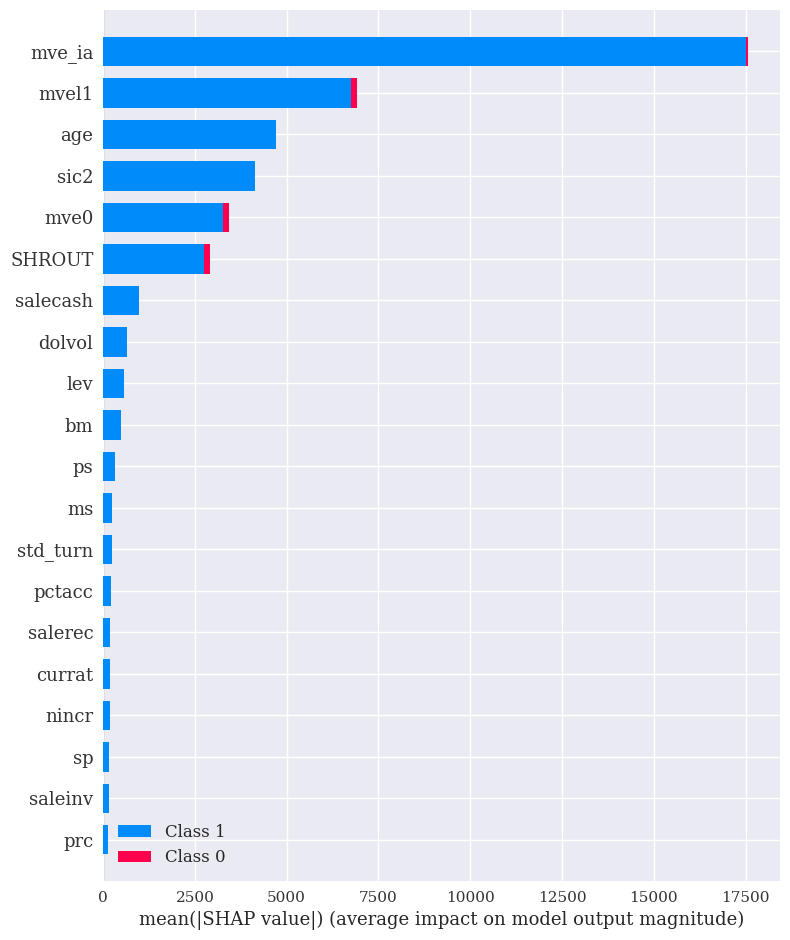

In [ ]:
#### show some results ####

expected_value = explainer.expected_value

# visulize the feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")
